## General info:

Data from [MTA](http://web.mta.info/developers/turnstile.html) <br>
Description of data [here](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)


[Our teams's GitHub for this project](https://github.com/huge-reality/MTA_Project_Group_5)

Someone else's solution [here](http://www.columbia.edu/~yh2693/MTA_data.html) and [here](https://pylearned.com/SubwayAnalysis/).

## Steps undertaken in this notebook
1. Read one week's worth of data, clean up column names
2. Add datetime elaborated info, remove Sat and Sun, tidy up unnecessary columns
3. Add a new column that bins the times of day: early, morning, midday, evening, night
4. Make two 'diff' columns, entries and exits, and one column that is their sum
    - Beforehand, sort by turnstile and then datetime to make sure the 'diff's are chronological <br><br>
6. Brute force clean up the difference data
7. Make a new dataframe that aggregates a groupby based on 'STATION'
    - The sum of the entry/exit <br><br>
    
8. Make another new column that represents the time elapsed between each of those 'diff' evaluations
    - Refactor that column so it is expressed using the "seconds since midnight" style of time <br><br>

9. Make two new columns that normalize the entries/exits differences by the amount of time elapsed

10. Do a groupby and aggregate sum of the normalized entries/exits for the morning, midday, and evening time bins

10. Two new columns: 1. Subtract midday from AM and 2. Subtract midday from PM. 
    - This should reveal stations that are heavy commuter stations for people going to work! <br><br>

11. Filter that new dataframe to *only* include values that are high for both am vs. midday and pm vs. midday

12. Make a graph of top stations!!

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.f' % x)


In [2]:
# read the data and remove spaces from column names
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

df = df1.append([df2, df3])

df.columns = df.columns.str.strip()


# add in two new columns, one that is a datetime (from the date and time columns)
# and one that is just the day of the week
df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format="%m/%d/%Y %H:%M:%S")
df['DAY'] = df['DATETIME'].dt.day_name()


# only look at M-F
df = df[(df["DAY"] != 'Saturday') & (df["DAY"] != 'Sunday')]

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441102 entries, 12 to 204087
Data columns (total 13 columns):
C/A         441102 non-null object
UNIT        441102 non-null object
SCP         441102 non-null object
STATION     441102 non-null object
LINENAME    441102 non-null object
DIVISION    441102 non-null object
DATE        441102 non-null object
TIME        441102 non-null object
DESC        441102 non-null object
ENTRIES     441102 non-null int64
EXITS       441102 non-null int64
DATETIME    441102 non-null datetime64[ns]
DAY         441102 non-null object
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 47.1+ MB
None


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,DAY
12,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2019,00:00:00,REGULAR,7028053,2382642,2019-04-22 00:00:00,Monday
13,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2019,04:00:00,REGULAR,7028064,2382644,2019-04-22 04:00:00,Monday
14,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2019,08:00:00,REGULAR,7028094,2382704,2019-04-22 08:00:00,Monday
15,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2019,12:00:00,REGULAR,7028239,2382891,2019-04-22 12:00:00,Monday
16,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2019,16:00:00,REGULAR,7028527,2382953,2019-04-22 16:00:00,Monday


In [3]:
df = df[(df['DESC'] == 'REGULAR')] 
del df['C/A']
del df['LINENAME']
del df['DIVISION']
del df['DESC']

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439627 entries, 12 to 204087
Data columns (total 9 columns):
UNIT        439627 non-null object
SCP         439627 non-null object
STATION     439627 non-null object
DATE        439627 non-null object
TIME        439627 non-null object
ENTRIES     439627 non-null int64
EXITS       439627 non-null int64
DATETIME    439627 non-null datetime64[ns]
DAY         439627 non-null object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 33.5+ MB
None


,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY
12,R051,02-00-00,59 ST,04/22/2019,00:00:00,7028053,2382642,2019-04-22 00:00:00,Monday
13,R051,02-00-00,59 ST,04/22/2019,04:00:00,7028064,2382644,2019-04-22 04:00:00,Monday
14,R051,02-00-00,59 ST,04/22/2019,08:00:00,7028094,2382704,2019-04-22 08:00:00,Monday
15,R051,02-00-00,59 ST,04/22/2019,12:00:00,7028239,2382891,2019-04-22 12:00:00,Monday
16,R051,02-00-00,59 ST,04/22/2019,16:00:00,7028527,2382953,2019-04-22 16:00:00,Monday


In [4]:
# make a new column where times between:
# 8 AM (inclusive) and 12 PM (exclusive) = morning
# 12 PM (inclusive) and 4 PM (exclusive) = midday
# 4 PM (inclusive) and 8 PM (exclusive) = evening

# start by making a function
def time_bin(time):
    if time >= '04:00:00' and time <= '08:00:00':
        return 'early'
    if time >= '08:00:00' and time <= '12:00:00':
        return 'morning'
    if time >= '12:00:00' and time <= '16:00:00':
        return 'midday'
    if time >= '16:00:00' and time <= '20:00:00':
        return 'evening'
    if time >= '20:00:00' and time <= '24:00:00':
        return 'night'
# then use apply to make a new column according to that function
df['time_bin'] = df['TIME'].apply(lambda row: time_bin(row))

# drop rows that don't fall within one of those bins
df = df[(df['time_bin'].notnull())] 

df.sort_values(['UNIT', 'SCP', 'DATETIME'], ascending=True, inplace = True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367631 entries, 10566 to 112933
Data columns (total 10 columns):
UNIT        367631 non-null object
SCP         367631 non-null object
STATION     367631 non-null object
DATE        367631 non-null object
TIME        367631 non-null object
ENTRIES     367631 non-null int64
EXITS       367631 non-null int64
DATETIME    367631 non-null datetime64[ns]
DAY         367631 non-null object
time_bin    367631 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 30.9+ MB
None


,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY,time_bin
10566,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,05:00:00,4245045,2604756,2019-04-22 05:00:00,Monday,early
10567,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,09:00:00,4245791,2604884,2019-04-22 09:00:00,Monday,morning
10568,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,13:00:00,4246376,2605089,2019-04-22 13:00:00,Monday,midday
10569,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,17:00:00,4247039,2605345,2019-04-22 17:00:00,Monday,evening
10570,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,21:00:00,4247565,2605686,2019-04-22 21:00:00,Monday,night


In [5]:
df.sort_values(['UNIT', 'SCP', 'DATETIME'], ascending=True, inplace = True)

df['exits_diff'] = df.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())
df['entries_diff'] = df.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
df['total_diff'] = df['entries_diff'] + df['exits_diff']


df = df[(df['exits_diff'] > 0)] 
df = df[(df['exits_diff'] < 15000)] 

df = df[(df['entries_diff'] > 0)] 
df = df[(df['entries_diff'] < 15000)] 


df = df[(df['total_diff'] > 0)] 
df = df[(df['total_diff'] < 15000)] 

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310417 entries, 10567 to 112933
Data columns (total 13 columns):
UNIT            310417 non-null object
SCP             310417 non-null object
STATION         310417 non-null object
DATE            310417 non-null object
TIME            310417 non-null object
ENTRIES         310417 non-null int64
EXITS           310417 non-null int64
DATETIME        310417 non-null datetime64[ns]
DAY             310417 non-null object
time_bin        310417 non-null object
exits_diff      310417 non-null float64
entries_diff    310417 non-null float64
total_diff      310417 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 33.2+ MB
None


,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY,time_bin,exits_diff,entries_diff,total_diff
10567,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,09:00:00,4245791,2604884,2019-04-22 09:00:00,Monday,morning,128,746,874
10568,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,13:00:00,4246376,2605089,2019-04-22 13:00:00,Monday,midday,205,585,790
10569,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,17:00:00,4247039,2605345,2019-04-22 17:00:00,Monday,evening,256,663,919
10570,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,21:00:00,4247565,2605686,2019-04-22 21:00:00,Monday,night,341,526,867
10572,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,05:00:00,4247728,2605771,2019-04-23 05:00:00,Tuesday,early,85,163,248


In [6]:
df['entries_time_diff'] = df.groupby(['UNIT', 'SCP', 'DAY'])['DATETIME'].transform(lambda x: x.diff())

df = df[(df['entries_time_diff'].notnull())] 
print(df.info())
print(df.entries_time_diff.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288921 entries, 10568 to 112933
Data columns (total 14 columns):
UNIT                 288921 non-null object
SCP                  288921 non-null object
STATION              288921 non-null object
DATE                 288921 non-null object
TIME                 288921 non-null object
ENTRIES              288921 non-null int64
EXITS                288921 non-null int64
DATETIME             288921 non-null datetime64[ns]
DAY                  288921 non-null object
time_bin             288921 non-null object
exits_diff           288921 non-null float64
entries_diff         288921 non-null float64
total_diff           288921 non-null float64
entries_time_diff    288921 non-null timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(7), timedelta64[ns](1)
memory usage: 33.1+ MB
None
count                    288921
mean     1 days 01:44:30.592158
std      2 days 04:48:44.723515
min             0 days 00:00:03
25%             

,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY,time_bin,exits_diff,entries_diff,total_diff,entries_time_diff
10568,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,13:00:00,4246376,2605089,2019-04-22 13:00:00,Monday,midday,205,585,790,04:00:00
10569,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,17:00:00,4247039,2605345,2019-04-22 17:00:00,Monday,evening,256,663,919,04:00:00
10570,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,21:00:00,4247565,2605686,2019-04-22 21:00:00,Monday,night,341,526,867,04:00:00
10573,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,09:00:00,4248569,2605874,2019-04-23 09:00:00,Tuesday,morning,103,841,944,04:00:00
10574,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,13:00:00,4249166,2606057,2019-04-23 13:00:00,Tuesday,midday,183,597,780,04:00:00


In [7]:
df = df[(df['entries_time_diff'] < '0 days 23:00:00') & (df['entries_time_diff'] > '0 days 00:00:00')]

print(df.entries_time_diff.describe())
print(df.info())
df.head()

count                    246687
mean     0 days 03:57:28.795583
std      0 days 00:42:51.650483
min             0 days 00:00:03
25%             0 days 04:00:00
50%             0 days 04:00:00
75%             0 days 04:00:00
max             0 days 18:17:50
Name: entries_time_diff, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 246687 entries, 10568 to 112933
Data columns (total 14 columns):
UNIT                 246687 non-null object
SCP                  246687 non-null object
STATION              246687 non-null object
DATE                 246687 non-null object
TIME                 246687 non-null object
ENTRIES              246687 non-null int64
EXITS                246687 non-null int64
DATETIME             246687 non-null datetime64[ns]
DAY                  246687 non-null object
time_bin             246687 non-null object
exits_diff           246687 non-null float64
entries_diff         246687 non-null float64
total_diff           246687 non-null float64
entries_t

,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY,time_bin,exits_diff,entries_diff,total_diff,entries_time_diff
10568,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,13:00:00,4246376,2605089,2019-04-22 13:00:00,Monday,midday,205,585,790,04:00:00
10569,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,17:00:00,4247039,2605345,2019-04-22 17:00:00,Monday,evening,256,663,919,04:00:00
10570,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,21:00:00,4247565,2605686,2019-04-22 21:00:00,Monday,night,341,526,867,04:00:00
10573,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,09:00:00,4248569,2605874,2019-04-23 09:00:00,Tuesday,morning,103,841,944,04:00:00
10574,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,13:00:00,4249166,2606057,2019-04-23 13:00:00,Tuesday,midday,183,597,780,04:00:00


In [8]:
df['seconds'] = df['entries_time_diff'].dt.seconds
print(df.seconds.describe())
df.head()

count   246687
mean     14249
std       2572
min          3
25%      14400
50%      14400
75%      14400
max      65870
Name: seconds, dtype: float64


,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY,time_bin,exits_diff,entries_diff,total_diff,entries_time_diff,seconds
10568,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,13:00:00,4246376,2605089,2019-04-22 13:00:00,Monday,midday,205,585,790,04:00:00,14400
10569,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,17:00:00,4247039,2605345,2019-04-22 17:00:00,Monday,evening,256,663,919,04:00:00,14400
10570,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,21:00:00,4247565,2605686,2019-04-22 21:00:00,Monday,night,341,526,867,04:00:00,14400
10573,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,09:00:00,4248569,2605874,2019-04-23 09:00:00,Tuesday,morning,103,841,944,04:00:00,14400
10574,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,13:00:00,4249166,2606057,2019-04-23 13:00:00,Tuesday,midday,183,597,780,04:00:00,14400


In [103]:
df['normalized_entries'] = df['entries_diff'] / df['seconds'] * 60 * 60
print(df.normalized_entries.describe())
df.head()

count   246687
mean        80
std         79
min          0
25%         26
50%         57
75%        110
max       3600
Name: normalized_entries, dtype: float64


,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY,time_bin,exits_diff,entries_diff,total_diff,entries_time_diff,seconds,normalized_entries,normalized_exits
10568,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,13:00:00,4246376,2605089,2019-04-22 13:00:00,Monday,midday,205,585,790,04:00:00,14400,146,14
10569,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,17:00:00,4247039,2605345,2019-04-22 17:00:00,Monday,evening,256,663,919,04:00:00,14400,166,18
10570,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,21:00:00,4247565,2605686,2019-04-22 21:00:00,Monday,night,341,526,867,04:00:00,14400,132,24
10573,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,09:00:00,4248569,2605874,2019-04-23 09:00:00,Tuesday,morning,103,841,944,04:00:00,14400,210,7
10574,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,13:00:00,4249166,2606057,2019-04-23 13:00:00,Tuesday,midday,183,597,780,04:00:00,14400,149,13


In [104]:
df['normalized_exits'] = df['exits_diff'] / df['seconds'] * 1000
print(df.normalized_exits.describe())
df.head()

count   246687
mean        17
std         22
min          0
25%          4
50%         10
75%         21
max        667
Name: normalized_exits, dtype: float64


,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME,DAY,time_bin,exits_diff,entries_diff,total_diff,entries_time_diff,seconds,normalized_entries,normalized_exits
10568,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,13:00:00,4246376,2605089,2019-04-22 13:00:00,Monday,midday,205,585,790,04:00:00,14400,146,14
10569,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,17:00:00,4247039,2605345,2019-04-22 17:00:00,Monday,evening,256,663,919,04:00:00,14400,166,18
10570,R001,00-00-00,WHITEHALL S-FRY,04/22/2019,21:00:00,4247565,2605686,2019-04-22 21:00:00,Monday,night,341,526,867,04:00:00,14400,132,24
10573,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,09:00:00,4248569,2605874,2019-04-23 09:00:00,Tuesday,morning,103,841,944,04:00:00,14400,210,7
10574,R001,00-00-00,WHITEHALL S-FRY,04/23/2019,13:00:00,4249166,2606057,2019-04-23 13:00:00,Tuesday,midday,183,597,780,04:00:00,14400,149,13


In [105]:
df2 = df[['STATION', 'time_bin', 'normalized_entries', 'normalized_exits']].copy()

print(df2.info())
df2.head(30)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 246687 entries, 10568 to 112933
Data columns (total 4 columns):
STATION               246687 non-null object
time_bin              246687 non-null object
normalized_entries    246687 non-null float64
normalized_exits      246687 non-null float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB
None


,STATION,time_bin,normalized_entries,normalized_exits
10568,WHITEHALL S-FRY,midday,146,14
10569,WHITEHALL S-FRY,evening,166,18
10570,WHITEHALL S-FRY,night,132,24
10573,WHITEHALL S-FRY,morning,210,7
10574,WHITEHALL S-FRY,midday,149,13
10575,WHITEHALL S-FRY,evening,165,22
10576,WHITEHALL S-FRY,night,167,27
10579,WHITEHALL S-FRY,morning,210,8
10580,WHITEHALL S-FRY,midday,158,12
10581,WHITEHALL S-FRY,evening,170,17


In [106]:

am_agg_exit = df2[(df2['time_bin'] == 'morning')].groupby(['STATION']).agg({'normalized_exits' : 'sum'})
mid_agg_exit = df2[(df2['time_bin'] == 'midday')].groupby(['STATION']).agg({'normalized_exits' : 'sum'})
mid_agg_entry = df2[(df2['time_bin'] == 'midday')].groupby(['STATION']).agg({'normalized_entries' : 'sum'})
pm_agg_entry = df2[(df2['time_bin'] == 'evening')].groupby(['STATION']).agg({'normalized_entries' : 'sum'})

am_agg_exit.rename(columns = {'normalized_exits':'am_exits'}, inplace = True) 

am_agg_exit.head()

,am_exits
STATION,
1 AV,6452
103 ST,4894
103 ST-CORONA,1527
104 ST,180
110 ST,1894


In [107]:
final = am_agg_exit

# add two new columns to include the mid-day and evening commute
# diff values
final['mid_exits'] = mid_agg_exit['normalized_exits'].values
final['mid_entries'] = mid_agg_entry['normalized_entries'].values
final['pm_entries'] = pm_agg_entry['normalized_entries'].values
final = final.reset_index()
final.head()

,STATION,am_exits,mid_exits,mid_entries,pm_entries
0,1 AV,6452,3992,15491,22767
1,103 ST,4894,3780,26255,29214
2,103 ST-CORONA,1527,2661,11880,10724
3,104 ST,180,285,2249,1657
4,110 ST,1894,1992,8788,9294


In [114]:
final['am_v_mid'] = final['am_exits'] - final['mid_exits']
final['pm_v_mid'] = final['pm_entries'] - final['mid_entries']

final = final[(final['am_v_mid'] > 500) & (final['pm_v_mid'] > 500)]

final = final.sort_values('pm_v_mid', ascending=False)



In [115]:
final.head()

,STATION,am_exits,mid_exits,mid_entries,pm_entries,am_v_mid,pm_v_mid
59,34 ST-HERALD SQ,44633,23338,83789,186658,21295,102869
72,47-50 STS ROCK,42085,10689,44179,142246,31396,98068
350,TIMES SQ-42 ST,40140,19188,64579,160643,20953,96064
232,GRD CNTRL-42 ST,57302,31553,88659,176692,25749,88032
313,PATH NEW WTC,26748,11672,16554,88533,15076,71979


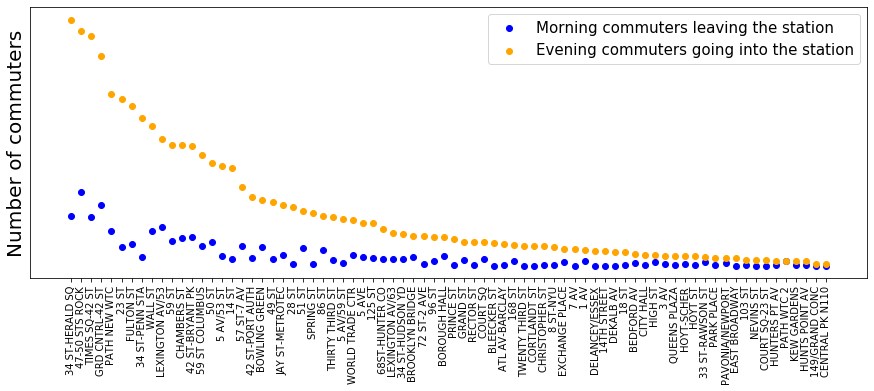

In [116]:
# final = final.reset_index()
x = final['STATION']
y1 = final['am_v_mid']
y2 = final['pm_v_mid']
plt.figure(figsize=(15,5))

plt.scatter(x, y1, color = 'b')
plt.scatter(x, y2, color = 'orange')
plt.legend(['Morning commuters leaving the station','Evening commuters going into the station'],
           loc = 0, frameon = True, fontsize = 15);

ticks_y = np.linspace(0, 0, 0)
plt.yticks(ticks_y, fontsize = '10', fontname = 'Helvetica');
plt.ylabel('Number of commuters',fontsize = 20);




plt.xticks(rotation='vertical');

plt.savefig('commuter_stations.png')